Loading datasets...

PART A: K-NN Implementation
K=1, euclidean: Accuracy=0.711
K=1, manhattan: Accuracy=0.711
K=3, euclidean: Accuracy=0.756
K=3, manhattan: Accuracy=0.756
K=5, euclidean: Accuracy=0.778
K=5, manhattan: Accuracy=0.800
K=7, euclidean: Accuracy=0.800
K=7, manhattan: Accuracy=0.778
K=9, euclidean: Accuracy=0.800
K=9, manhattan: Accuracy=0.778

PART B: Naive Bayes Implementation
Multinomial NB Accuracy: 0.984
Gaussian NB Accuracy: 0.865

Probability comparison (first 3 samples):
Sample 1: MNB[ham=1.000, spam=0.000] | GNB[ham=0.478, spam=0.522]
Sample 2: MNB[ham=1.000, spam=0.000] | GNB[ham=0.497, spam=0.503]
Sample 3: MNB[ham=1.000, spam=0.000] | GNB[ham=0.671, spam=0.329]

PART C: Algorithm Comparison

Algorithm Comparison Table:
           Algorithm Accuracy Train Time (ms) Pred Time (ms)
         K-NN (Iris)    0.778            1.26           2.63
  Gaussian NB (Iris)    0.822            1.55           0.43
          K-NN (SMS)    0.925            3.79        1048.53
Mu

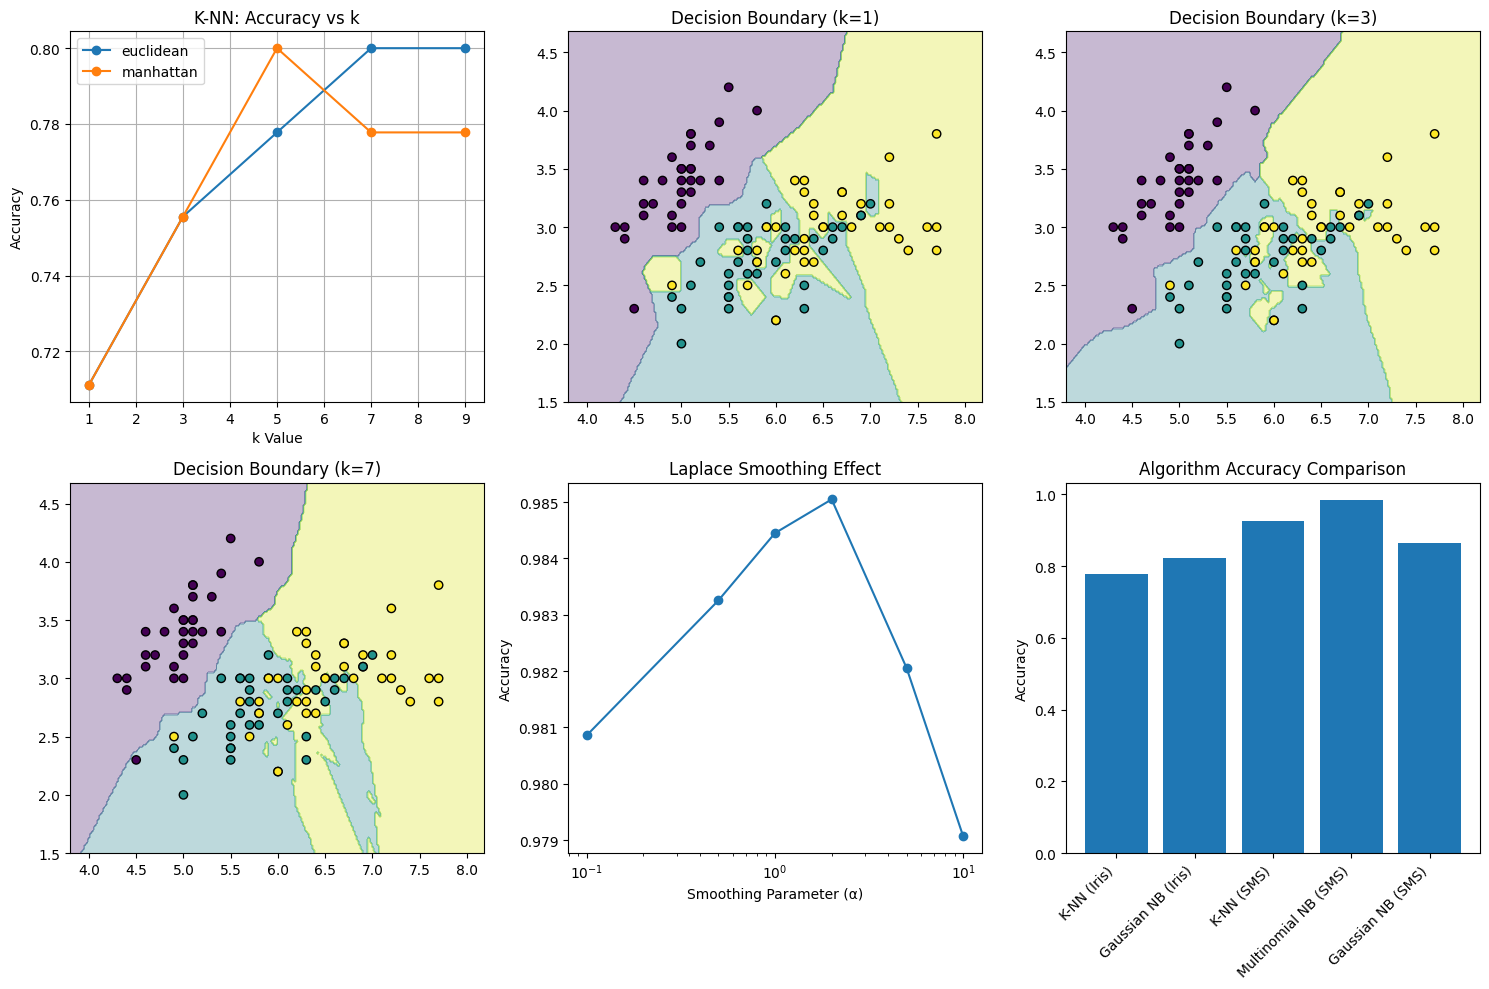

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time
import string

print("Loading datasets...")

iris = load_iris()

df_sms = pd.read_csv(
    'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv',
    sep='\t',
    names=['label', 'message']
)

# ==========================
# PART A: K-NN
# ==========================

print("\n" + "="*50)
print("PART A: K-NN Implementation")
print("="*50)

X_iris = iris.data[:, :2]
y_iris = iris.target

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42
)

k_values = [1, 3, 5, 7, 9]
results_knn = []

for k in k_values:
    for metric in ['euclidean', 'manhattan']:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train_i, y_train_i)
        acc = accuracy_score(y_test_i, knn.predict(X_test_i))
        results_knn.append([k, metric, acc])
        print(f"K={k}, {metric}: Accuracy={acc:.3f}")

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)

df_knn = pd.DataFrame(results_knn, columns=['k', 'metric', 'accuracy'])

for metric in ['euclidean', 'manhattan']:
    data = df_knn[df_knn['metric'] == metric]
    plt.plot(data['k'], data['accuracy'], marker='o', label=metric)

plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.title('K-NN: Accuracy vs k')
plt.legend()
plt.grid(True)

# Decision Boundaries
for idx, k in enumerate([1, 3, 7], 2):

    plt.subplot(2, 3, idx)

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_i, y_train_i)

    x_min, x_max = X_train_i[:, 0].min()-0.5, X_train_i[:, 0].max()+0.5
    y_min, y_max = X_train_i[:, 1].min()-0.5, X_train_i[:, 1].max()+0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.02),
        np.arange(y_min, y_max, 0.02)
    )

    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train_i[:, 0], X_train_i[:, 1], c=y_train_i, edgecolor='k')

    plt.title(f'Decision Boundary (k={k})')

# ==========================
# PART B: Naive Bayes
# ==========================

print("\n" + "="*50)
print("PART B: Naive Bayes Implementation")
print("="*50)

df_sms['label'] = df_sms['label'].map({'ham': 0, 'spam': 1})
df_sms['processed'] = df_sms['message'].str.lower().str.replace(f'[{string.punctuation}]', '', regex=True)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    df_sms['processed'], df_sms['label'], test_size=0.3, random_state=42
)

vectorizer = CountVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train_s)
X_test_vec = vectorizer.transform(X_test_s)

X_train_num = np.array([[len(msg), len(msg.split())] for msg in X_train_s])
X_test_num = np.array([[len(msg), len(msg.split())] for msg in X_test_s])

mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train_s)
acc_mnb = accuracy_score(y_test_s, mnb.predict(X_test_vec))
print(f"Multinomial NB Accuracy: {acc_mnb:.3f}")

gnb = GaussianNB()
gnb.fit(X_train_num, y_train_s)
acc_gnb = accuracy_score(y_test_s, gnb.predict(X_test_num))
print(f"Gaussian NB Accuracy: {acc_gnb:.3f}")

# Laplace Smoothing
plt.subplot(2, 3, 5)

alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
accuracies = []

for alpha in alphas:
    mnb_smooth = MultinomialNB(alpha=alpha)
    mnb_smooth.fit(X_train_vec, y_train_s)
    acc = accuracy_score(y_test_s, mnb_smooth.predict(X_test_vec))
    accuracies.append(acc)

plt.plot(alphas, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Smoothing Parameter (α)')
plt.ylabel('Accuracy')
plt.title('Laplace Smoothing Effect')

print("\nProbability comparison (first 3 samples):")
probs_mnb = mnb.predict_proba(X_test_vec)[:3]
probs_gnb = gnb.predict_proba(X_test_num)[:3]

for i in range(3):
    print(f"Sample {i+1}: MNB[ham={probs_mnb[i][0]:.3f}, spam={probs_mnb[i][1]:.3f}] "
          f"| GNB[ham={probs_gnb[i][0]:.3f}, spam={probs_gnb[i][1]:.3f}]")

# ==========================
# PART C: Comparison
# ==========================

print("\n" + "="*50)
print("PART C: Algorithm Comparison")
print("="*50)

def evaluate_algo(model, X_train, X_test, y_train, y_test, name):

    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    start = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start

    acc = accuracy_score(y_test, y_pred)

    return {
        'Algorithm': name,
        'Accuracy': f"{acc:.3f}",
        'Train Time (ms)': f"{train_time*1000:.2f}",
        'Pred Time (ms)': f"{pred_time*1000:.2f}"
    }

results = []

results.append(evaluate_algo(
    KNeighborsClassifier(n_neighbors=5),
    X_train_i, X_test_i, y_train_i, y_test_i,
    "K-NN (Iris)"
))

results.append(evaluate_algo(
    GaussianNB(),
    X_train_i, X_test_i, y_train_i, y_test_i,
    "Gaussian NB (Iris)"
))

results.append(evaluate_algo(
    KNeighborsClassifier(n_neighbors=5),
    X_train_vec.toarray(), X_test_vec.toarray(),
    y_train_s, y_test_s,
    "K-NN (SMS)"
))

results.append(evaluate_algo(
    MultinomialNB(),
    X_train_vec, X_test_vec,
    y_train_s, y_test_s,
    "Multinomial NB (SMS)"
))

results.append(evaluate_algo(
    GaussianNB(),
    X_train_num, X_test_num,
    y_train_s, y_test_s,
    "Gaussian NB (SMS)"
))

df_comparison = pd.DataFrame(results)

print("\nAlgorithm Comparison Table:")
print(df_comparison.to_string(index=False))

plt.subplot(2, 3, 6)

x_pos = np.arange(len(results))
accuracies = [float(r['Accuracy']) for r in results]

plt.bar(x_pos, accuracies)
plt.xticks(x_pos, [r['Algorithm'] for r in results], rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Algorithm Accuracy Comparison')

plt.tight_layout()
plt.show()
